### 1. Reading Raw Data


In [640]:
import pandas as pd
import numpy as np
import os

# %cd ..
#gdis data - geocoded disasters
gdis = pd.read_csv('data/disaster/pend-gdis-1960-2018-disasterlocations.csv')
# #emdat data - international disasters
emdat = pd.read_csv('data/disaster/emdat_public_2022_09_21_query_uid-47Yzpr.csv', skiprows=[0,1,2,3,4,5])

/var/folders/1d/zrkty6fd25b94gwy6539wfkw0000gn/T/ipykernel_95384/1305961257.py:9: DtypeWarning: Columns (8,16,17,18,19,24,25,26,27,46,48) have mixed types. Specify dtype option on import or set low_memory=False.
  emdat = pd.read_csv('data/disaster/emdat_public_2022_09_21_query_uid-47Yzpr.csv', skiprows=[0,1,2,3,4,5])


In [641]:
#select certain columns from emdat and join with gdis
emdat['disasterno'] = emdat['Dis No'].str[:-4] #format disasterno to merge
cols = ['disasterno', 'Year', 'Event Name',
        'Start Year', 'Start Month', 'Start Day',
        'End Year', 'End Month','End Day',
        "Total Damages, Adjusted ('000 US$)"]

emdat = emdat[cols]

In [642]:
#join emdat and gdis
gdis = pd.merge(emdat, gdis, on = 'disasterno', how='right')

In [643]:
gdis = gdis.drop_duplicates(subset=['id'])
print('shape', gdis.shape)
gdis.head(3)

shape (9924, 27)


,disasterno,Year,Event Name,Start Year,Start Month,Start Day,End Year,End Month,End Day,"Total Damages, Adjusted ('000 US$)",...,level,adm1,adm2,adm3,location,historical,hist_country,disastertype,latitude,longitude
0,2009-0631,2009.0,NaN,2009.0,12.0,27.0,2010.0,1.0,8.0,NaN,...,3,Shkoder,Shkodres,Ana E Malit,Ana E Malit,0,NaN,flood,42.020948,19.418317
2,2001-0146,2001.0,NaN,2001.0,4.0,2.0,2001.0,4.0,9.0,NaN,...,3,Cunene,Cuanhama,Onjiva,Onjiva,0,NaN,flood,-17.093484,15.665758
3,2009-0092,2009.0,NaN,2009.0,3.0,1.0,2009.0,4.0,16.0,NaN,...,3,Cunene,Cuanhama,Evale,Evale,0,NaN,flood,-16.531533,15.773987


In [644]:
# gdis['lat_grid'] = np.digitize(np.array(gdis['latitude']),np.arange(-90,90,1))
# gdis['lon_grid'] = np.digitize(np.array(gdis['longitude']),np.arange(-180,180,1))
# #compute the grid pair id
# gdis['grid_id'] = list(zip(gdis['lat_grid'],gdis['lon_grid']))

# new grid_id: round to integers
gdis['lat_grid'] = gdis['latitude'].round().astype(int)
gdis['lon_grid'] = gdis['longitude'].round().astype(int)
gdis['grid_id'] = list(zip(gdis['lat_grid'],gdis['lon_grid']))
print('total number of grid pairs', len(gdis.grid_id.value_counts()))

# check if they lie in range
print('lon range', gdis['lon_grid'].min(), gdis['lon_grid'].max())
print('lat range', gdis['lat_grid'].min(), gdis['lat_grid'].max())

total number of grid pairs 2827
lon range -178 180
lat range -54 68


### 2. Construct X

In [645]:
#pivot function: change rows of info into tables
def pivot(df_in, id_col='disastertype', id_list=['Flood']):
    """
    Transform the input DataFrame by pivoting disaster-related information into separate columns.

    This function creates binary and aggregated columns for specified disaster types based on the input DataFrame.
    It initializes three new columns for each disaster type: a binary indicator, the total adjusted damages,
    and a count of occurrences.

    Parameters:
    df_in (pd.DataFrame): The input DataFrame containing disaster information, including the specified
                          disaster type and total damages.
    id_col (str): The name of the column in the input DataFrame that contains the disaster type information.
                   Defaults to 'disastertype'.
    id_list (list): A list of disaster types to pivot. Each type will create corresponding columns in the output
                    DataFrame. Defaults to ['Flood'].

    Returns:
    pd.DataFrame: A DataFrame with additional columns for each disaster type in the id_list, including:
                  - A binary indicator column for the presence of the disaster type (e.g., 'Flood_bin').
                  - A column for the total adjusted damages related to that disaster type (e.g., 'Flood_amt').
                  - A count column indicating the number of occurrences of the disaster type (e.g., 'Flood_ct').
    """
    df = df_in.reset_index(drop = True)
    for id in id_list:
        #initialize columns
        df[id+'_bin'] = 0
        df[id+'_amt'] = 0
        df[id+'_ct'] = 0
        df.loc[(df[id_col]==id), id+'_bin'] = 1
        df.loc[(df[id_col]==id), id+'_amt'] = df["Total Damages, Adjusted ('000 US$)"].astype(float)
        df.loc[(df[id_col]==id), id+'_ct'] = 1
    return df

In [646]:
id_list= gdis['disastertype'].unique().tolist()
print(id_list)
df_pivot= pivot(gdis, id_col = 'disastertype', id_list = id_list)
df_pivot

['flood', 'storm', 'earthquake', 'extreme temperature ', 'landslide', 'volcanic activity', 'drought', 'mass movement (dry)']


,disasterno,Year,Event Name,Start Year,Start Month,Start Day,End Year,End Month,End Day,"Total Damages, Adjusted ('000 US$)",...,landslide_ct,volcanic activity_bin,volcanic activity_amt,volcanic activity_ct,drought_bin,drought_amt,drought_ct,mass movement (dry)_bin,mass movement (dry)_amt,mass movement (dry)_ct
0,2009-0631,2009.0,NaN,2009.0,12.0,27.0,2010.0,1.0,8.0,NaN,...,0,0,0.0,0,0,0.0,0,0,0.0,0
1,2001-0146,2001.0,NaN,2001.0,4.0,2.0,2001.0,4.0,9.0,NaN,...,0,0,0.0,0,0,0.0,0,0,0.0,0
2,2009-0092,2009.0,NaN,2009.0,3.0,1.0,2009.0,4.0,16.0,NaN,...,0,0,0.0,0,0,0.0,0,0,0.0,0
3,2010-0105,2010.0,NaN,2010.0,3.0,1.0,2010.0,3.0,17.0,NaN,...,0,0,0.0,0,0,0.0,0,0,0.0,0
4,1995-0082,1995.0,NaN,1995.0,5.0,15.0,1995.0,5.0,15.0,1422569.0,...,0,0,0.0,0,0,0.0,0,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9919,1960-0011,1960.0,Manam,1960.0,3.0,17.0,1960.0,3.0,17.0,NaN,...,0,1,NaN,1,0,0.0,0,0,0.0,0
9920,2009-9633,2009.0,NaN,2009.0,NaN,NaN,2010.0,NaN,NaN,NaN,...,0,0,0.0,0,1,NaN,1,0,0.0,0
9921,1990-9289,1990.0,NaN,1990.0,NaN,NaN,1990.0,NaN,NaN,NaN,...,0,0,0.0,0,1,NaN,1,0,0.0,0
9922,1969-9069,1969.0,NaN,1969.0,NaN,NaN,1971.0,NaN,NaN,73867.0,...,0,0,0.0,0,1,73867.0,1,0,0.0,0


In [647]:
#aggregate columns by year
def aggregate_yrly(df):
    """
    Aggregate yearly disaster-related data by grid ID and year.

    This function consolidates counts, amounts, and binary indicators of disaster events
    for each unique grid ID and year. It groups the input DataFrame by these identifiers
    and aggregates the relevant columns accordingly.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing disaster data, including counts,
                       amounts, binary indicators, and additional metadata such as
                       latitude and longitude.

    Returns:
    pd.DataFrame: A DataFrame indexed by grid ID and year, containing the aggregated
                  values for:
                  - Counts (sum) of events (columns ending with '_ct').
                  - Amounts (sum) of total damages (columns ending with '_amt').
                  - Binary indicators (max) for the occurrence of events (columns ending with '_bin').
                  - Additional metadata (latitude, longitude, start and end dates) for each grid ID and year.
    """
    #aggregate count
    col_ct = [col for col in df.columns if '_ct' in col]
    df_ct = df.groupby(['grid_id', 'year'])[col_ct].agg('sum')

    # Aggregate amount
    col_amt = [col for col in df.columns if '_amt' in col]
    df_amt = df.groupby(['grid_id', 'year'])[col_amt].agg('sum')

    # Aggregate binary
    col_bin = [col for col in df.columns if '_bin' in col]
    df_bin = df.groupby(['grid_id', 'year'])[col_bin].agg('max')

    # Additional columns to include
    additional_cols = ['latitude', 'longitude', 'Start Year', 'Start Month', 'Start Day', 'End Year', 'End Month', 'End Day']

    # Select the additional columns and drop duplicates
    df_additional = df.groupby(['grid_id', 'year'])[additional_cols].first()

    # Join all the DataFrames
    df_final = pd.concat([df_amt, df_ct, df_bin, df_additional], axis=1)

    return df_final.reset_index()

# df_pivot.head(30)
df_yrly = aggregate_yrly(df_pivot)
# df_yrly.head(10)
df_yrly.shape


(8691, 34)

flood_ct
0           991
1           984
2           376
3           181
4            91
Name: count, dtype: int64


array([[<Axes: title={'center': 'flood_ct'}>]], dtype=object)

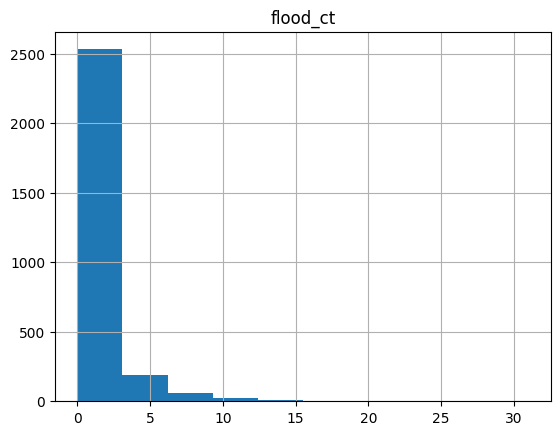

In [648]:
#count how many flood for each grid over all data
#sum grid id with total flood incidents
flood_ct = df_yrly.groupby('grid_id').agg({'flood_ct':'sum'})
print(flood_ct.value_counts().head(5))
flood_ct.hist() #[['grid_id','flood_ct']]

#1032 grids have no flood before, 983 have 1 flood only, 361 have 2 floods

In [649]:
len(df_yrly)

8691

### 3. Construct Y Master

In [650]:
bin_col =  [col for col in df_yrly.columns if '_bin' in col]
df_yrly_bin = df_yrly[['grid_id','year'] + bin_col]

In [651]:
# #get a list of disasters and flood_id
all_dis = gdis[['grid_id','Year','disastertype']]
flood = all_dis.loc[all_dis['disastertype']=='flood']
flood

,grid_id,Year,disastertype
0,"(42, 19)",2009.0,flood
2,"(-17, 16)",2001.0,flood
3,"(-17, 16)",2009.0,flood
18,"(-17, 16)",2010.0,flood
27,"(23, 92)",2000.0,flood
...,...,...,...
82550,"(15, -90)",2018.0,flood
82732,"(23, 91)",1964.0,flood
82734,"(25, 92)",1966.0,flood
82735,"(14, 46)",1981.0,flood


In [652]:
# get a list of grid_ids
grid_id = gdis['grid_id'].unique()
# get a list of year information
print(gdis.Year.min(), gdis.Year.max())
year_id = np.arange(1960, 2019, 1)
#create multi-index: each grid id, spanning over the years
idd = pd.MultiIndex.from_product([grid_id, year_id],
                           names=['grid_id', 'year'])

#length should be |years| * |grid_ids|
print(len(idd))
#get dataframe
idd = idd.to_frame().reset_index(drop=True)

1960.0 2018.0
166793


In [653]:
#master disaster targets for all years and all ids:
#All historical flood events are captured for each location and year
#merge with df_yrly
y_master = pd.merge(idd, df_yrly_bin, on=['grid_id','year'], how='left').fillna(0)

In [654]:
#check:
print(y_master['flood_bin'].sum()) #total number of binary flood targets

#total number of flood incidents:
print(gdis.loc[gdis['disastertype']=='flood'].shape[0])

#the two numbers are slightly different, but that's because some country have more than 1 flood per year

4015.0
4274


### 4. Filter data to previously flooded regions

In [655]:
#step 1: filter xy_df to those grid_ids with previous frequent flooding history
agg = df_yrly.groupby('grid_id').agg({'flood_bin':'sum'})
grid_id_ls = agg.loc[agg['flood_bin']>=2].index.tolist()
print('no of grid_ids selected', len(grid_id_ls))


#step 2: interpolate years to record all years, fill with 0 without any flood using idd
#create multi-index: each grid id, spanning over the years
year_id = np.arange(1960, 2019, 1)
idd = pd.MultiIndex.from_product([grid_id_ls, year_id],
                           names=['grid_id', 'year'])

#length should be |years| * |grid_ids|
print('len of idd', len(idd))
#get dataframe
idd = idd.to_frame().reset_index(drop=True)

no of grid_ids selected 830
len of idd 48970


### 5. Attach NLP

In [667]:
import ast
from sklearn.model_selection import train_test_split


In [668]:
def to_tuple(df):
  '''
  grid_id is a string, convert to tuple if not already
  '''
  df['grid_id'] = df['grid_id'].apply(lambda t: t if type(t) == tuple else ast.literal_eval(t))
  return df

In [669]:
df_nlp_transfer = pd.read_csv('data/nlp/df_cls_transfer128.csv') ##128 transfer learning
df_nlp = to_tuple(df_nlp_transfer)
df_nlp_new = to_tuple(pd.read_pickle('data/nlp/nlp_cls_transfer_new.pkl'))

In [670]:
def attach_target(x_df, y_master, disaster, next_n):
    # Create a copy of y_master with only the necessary columns
    y_master = y_master[['grid_id', 'year', disaster + '_bin']].rename(
        columns={disaster + '_bin': 'disaster_bin'}
    )
    
    # Create a new DataFrame to avoid modifying the original x_df
    x_df_copy = x_df.copy()
    
    # Define the target column name
    target_col = 'target_' + disaster + '_' + str(next_n)
    
    # Initialize the target column to 0
    x_df_copy[target_col] = 0
    
    # Iterate over the next_n years to check for disasters
    for i in range(1, next_n + 1):
        temp_df = x_df_copy.copy()
        temp_df['year'] += i
        
        # Merge with y_master to check for disasters
        merged_df = temp_df.merge(y_master, on=['grid_id', 'year'], how='left')
        
        # Update the target column if a disaster is found
        x_df_copy[target_col] |= merged_df['disaster_bin'].fillna(0).astype(bool)
    
    # Convert the target column to integers
    x_df_copy[target_col] = x_df_copy[target_col].astype(int)
    
    return x_df_copy
# def attach_target(x_df, y_master, disaster, next_n):
#     y = y_master.copy()
#     #shift years
#     y['year'] = y['year'] - next_n
#     #keep for particular disaster
#     y = y[['grid_id','year',disaster+'_bin']]
#     # Rename into target
#     y = y.rename(columns={disaster +'_bin': 'target_' + disaster + '_'+ str(next_n)})
#     xy_df = pd.merge(x_df, y, on = ['grid_id','year'], how='inner')
#     return xy_df

In [671]:
x_df = df_yrly.loc[df_yrly['grid_id'].isin(grid_id_ls)]
x_df = pd.merge(idd, x_df, on=['grid_id','year'], how='left').fillna(0)
x_df[['lat', 'lon']] = pd.DataFrame(x_df['grid_id'].tolist(), index=x_df.index)
print('length of x_df', len(x_df))
x_df = x_df.rename(columns={col: f'stat_{col}' for col in x_df.columns if col not in ['grid_id', 'year']})


length of x_df 48970


In [672]:
def attach_nlp(xy_df, df_nlp):
    #correct formatting for df_nlp
    df_nlp = string_to_tuple(df_nlp, 'grid_id')
    #drop text, location and label columns
    df_nlp = df_nlp.drop(['location','txt','label','flood_ct'], axis=1)
    #add prefix
    df_nlp = df_nlp.rename(columns={c: 'nlp_' + str(c) for c in df_nlp.columns if c not in ['grid_id']})
    #merge
    xy_df_out = pd.merge(xy_df, df_nlp , on='grid_id', how='left')
    print('shape of xy_df with nlp features', xy_df_out.shape)
    return xy_df_out

#format function for above
def string_to_tuple(df, col):
    try:
        df[col] = df.apply(lambda row: eval(row[col]), axis=1)
    except:
        'error converting to tuple'
    return df

In [673]:

n_pred = 1

#attach nlp features
x_df = attach_nlp(x_df, df_nlp_new)
x_df = x_df.drop([
        'stat_latitude', 'stat_longitude', 
        'stat_Start Year', 'stat_Start Month', 
        'stat_Start Day', 'stat_End Year', 'stat_End Month', 'stat_End Day'
    ], axis=1)


shape of xy_df with nlp features (48970, 69)


In [674]:
xy_df = attach_target(x_df, y_master, 'flood', n_pred)
print('length of xy_df', len(xy_df))
print('imbalance', xy_df.filter(regex='target').sum()/len(xy_df))



length of xy_df 48970
imbalance target_flood_1    0.113498
dtype: float64


In [675]:
# xy_df.to_csv('data/xy_df_new_process/xy_df_sub5.csv')

### quick test

In [676]:

#try to run a fast xgb model on stats only features:

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
#split training and testing
from sklearn.model_selection import train_test_split
import utils

results = {}
# Separate features (X) and targets (y)
x = xy_df.drop(xy_df.filter(regex='target').columns, axis=1)  # Drop target columns
x = x.select_dtypes(['number'])  # Keep only numerical columns
y = xy_df.filter(regex='target')  # Keep only target columns

# Get the 'year' column
years = xy_df['year']

# Determine the split based on years
min_year, max_year = years.min(), years.max()
unique_years = np.sort(years.unique())
split_year = unique_years[int(len(unique_years) * 0.8)]  # 80% split point
print("split_year is", split_year)

# Split data chronologically
train_mask = years <= split_year
test_mask = years > split_year


#filter to stats only features
x_stat = x.filter(regex='stat')
x_stat_nlp = x.filter(regex='stat|nlp')
x_nlp = x.filter(regex='nlp')
print('stat feature no.', x_stat.shape[1])
print('stat_nlp feature no.', x_stat_nlp.shape[1])

split_year is 2007
stat feature no. 26
stat_nlp feature no. 59


In [677]:
x1 = x_stat.copy()
x_train1, x_test1 = x1[train_mask], x1[test_mask]
y_train1, y_test1 = y[train_mask], y[test_mask]

print(x_train1.shape, x_test1.shape, y_train1.shape, y_test1.shape)
print("data imbalance train", y_train1.sum()/len(y_train1['target_flood_1']))
print("data imbalance test", y_test1.sum()/len(y_test1['target_flood_1']))

# # Evaluate the model
y_pred, y_pred_prob = utils.run_xgb(x_train1, y_train1, x_test1)
results['stats only chrono split'] = utils.get_scores_clf(y_test1, y_pred_prob)

(39840, 26) (9130, 26) (39840, 1) (9130, 1)
data imbalance train target_flood_1    0.092169
dtype: float64
data imbalance test target_flood_1    0.206572
dtype: float64
running xgb...
[10, 20, 65]
Train AUC:  0.818876240790376
{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'scale_pos_weight': 10}
maximum f1 score, thres 0.8356509373231152 0.7
auc, f1, accu, accu_bl, precision, recall=  0.7935561400724803 0.8356509373231152 0.9102957283680175 0.7852268714870185 0.6542075208911439 0.5721102863202545
[[7232   12]
 [ 807 1079]]
